# AnyoneAI - Project II

# Making Estimations with our NBA dataset

In our first project, we learn how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using ScikitLearn

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

### Analyzing our data

In [2]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns

from numpy.ma.core import fix_invalid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from numpy import array
from numpy import argmax
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

In [4]:
'''
First step:
analyze data in order to complete understanding of total values of columns and columns data types
'''

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PERSON_ID     460 non-null    int64  
 1   PLAYER_NAME   460 non-null    object 
 2   TEAM_NAME     438 non-null    object 
 3   POSITION      460 non-null    object 
 4   HEIGHT        460 non-null    int64  
 5   WEIGHT        460 non-null    int64  
 6   COUNTRY       460 non-null    object 
 7   BIRTHDATE     460 non-null    object 
 8   SEASON_EXP    460 non-null    int64  
 9   DRAFT_NUMBER  456 non-null    object 
 10  GP            459 non-null    float64
 11  MIN           459 non-null    float64
 12  PTS           459 non-null    float64
 13  REB           459 non-null    float64
 14  AST           459 non-null    float64
 15  STL           459 non-null    float64
 16  BLK           459 non-null    float64
 17  GAME_DATE     439 non-null    object 
 18  Salary        460 non-null    

In [5]:
'''
Delete from our data nulls
'''

data.dropna(subset=["PTS"], inplace=True)

In [6]:
'''
Delete NA in team name
'''

data.dropna(subset=["TEAM_NAME"], inplace=True)

In [7]:
'''
Now, as we can see, all columns have the same len thanks to data cleaning performed before
'''

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437 entries, 0 to 459
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PERSON_ID     437 non-null    int64  
 1   PLAYER_NAME   437 non-null    object 
 2   TEAM_NAME     437 non-null    object 
 3   POSITION      437 non-null    object 
 4   HEIGHT        437 non-null    int64  
 5   WEIGHT        437 non-null    int64  
 6   COUNTRY       437 non-null    object 
 7   BIRTHDATE     437 non-null    object 
 8   SEASON_EXP    437 non-null    int64  
 9   DRAFT_NUMBER  435 non-null    object 
 10  GP            437 non-null    float64
 11  MIN           437 non-null    float64
 12  PTS           437 non-null    float64
 13  REB           437 non-null    float64
 14  AST           437 non-null    float64
 15  STL           437 non-null    float64
 16  BLK           437 non-null    float64
 17  GAME_DATE     436 non-null    object 
 18  Salary        437 non-null    

In [8]:
'''
Visualize our cleaned data
'''

data

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,Salary,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,1,20,115.0,17.3,6.5,5.1,0.8,0.4,0.5,2022-03-06,2711280,"22 years, 5 months, 25 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,8,12,648.0,26.8,9.3,7.9,1.4,0.9,0.9,2022-03-06,17073171,"28 years, 7 months, 24 days"
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,4,14,326.0,28.0,13.2,8.2,3.5,1.0,0.9,2022-03-07,28103550,"24 years, 7 months, 26 days"
3,1630583,Santi Aldama,Grizzlies,Forward,211,98,Spain,2001-01-10,0,30,27.0,10.2,3.3,2.4,0.5,0.1,0.3,2022-03-06,1994520,"21 years, 2 months, 6 days"
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,15,2,1073.0,33.7,19.1,8.1,1.9,0.7,1.1,2022-03-06,2641691,"36 years, 7 months, 25 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,201152,Thaddeus Young,Raptors,Forward,203,107,USA,1988-06-21,14,12,1066.0,29.5,12.9,5.9,1.8,1.4,0.4,2022-03-06,14190000,"33 years, 8 months, 23 days"
456,1629027,Trae Young,Hawks,Guard,185,74,USA,1998-09-19,3,5,262.0,33.4,25.0,3.9,9.0,0.9,0.2,2022-03-07,8326471,"23 years, 5 months, 25 days"
457,1630209,Omer Yurtseven,Heat,Center,211,125,Turkey,1998-06-19,0,Undrafted,45.0,13.7,6.0,5.7,1.0,0.3,0.4,2022-03-07,1489065,"23 years, 8 months, 25 days"
458,203469,Cody Zeller,Hornets,Forward,211,109,USA,1992-10-05,9,4,494.0,22.2,8.5,6.0,1.4,0.6,0.6,NaN,2389641,"29 years, 5 months, 11 days"


Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

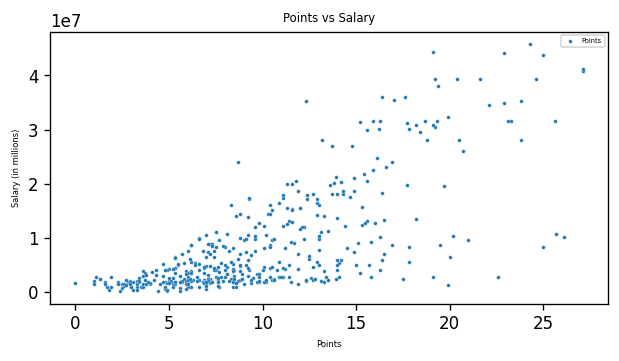

In [9]:
plt.figure(figsize=(6,3), dpi=120)

sns.scatterplot(data = data, x = "PTS", y = "Salary", s=5)

plt.title('Points vs Salary', fontsize = 7)
plt.xlabel('Points', fontsize = 5)
plt.ylabel('Salary (in millions)', fontsize = 5)
plt.legend(["Points", "Salary"], fontsize = 4)

plt.show()

In [10]:
'''
With regards the information about Salaries and Points made by each player
we can find a tendency of direct correlation between both variables.
Though is clarly exposed that players up to a total average of 10 points scored
are the ones with lowest salaries, when it comes to higher scores, tendency
is not as clear as it has been.
There are players with high salaries who have scored the highest but,
also there are players with the similar achivement whose salary is well below.
Then, even though the salaries and points scored tend to be positively and directly
related, it is not clear for all cases and dispersion increases at higher score levels.
'''

'\nWith regards the information about Salaries and Points made by each player\nwe can find a tendency of direct correlation between both variables.\nThough is clarly exposed that players up to a total average of 10 points scored\nare the ones with lowest salaries, when it comes to higher scores, tendency\nis not as clear as it has been.\nThere are players with high salaries who have scored the highest but,\nalso there are players with the similar achivement whose salary is well below.\nThen, even though the salaries and points scored tend to be positively and directly\nrelated, it is not clear for all cases and dispersion increases at higher score levels.\n'

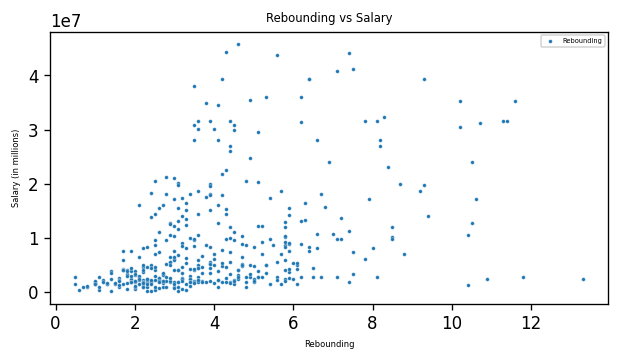

In [11]:
plt.figure(figsize=(6,3), dpi=120)

sns.scatterplot(data = data, x = "REB", y = "Salary", s=5)

plt.title('Rebounding vs Salary', fontsize = 7)
plt.xlabel('Rebounding', fontsize = 5)
plt.ylabel('Salary (in millions)', fontsize = 5)
plt.legend(["Rebounding", "Salary"], fontsize = 4)

plt.show()

In [12]:
'''
With regards the information about Salaries and Reboundings made by each player,
the tendency is not as clear as expected.
Though the huge majority of cases are situated bottom end of 3rd quadrant,
meaning lack of rebounds, lower salaries, there is not a fair relation between
both variables in all the other situations analized.
There are high salaries with low number of rebounds and some cases on the other
way around. So that, relationship within varibles is not fully appreciated.
'''

'\nWith regards the information about Salaries and Reboundings made by each player,\nthe tendency is not as clear as expected.\nThough the huge majority of cases are situated bottom end of 3rd quadrant,\nmeaning lack of rebounds, lower salaries, there is not a fair relation between\nboth variables in all the other situations analized.\nThere are high salaries with low number of rebounds and some cases on the other\nway around. So that, relationship within varibles is not fully appreciated.\n'

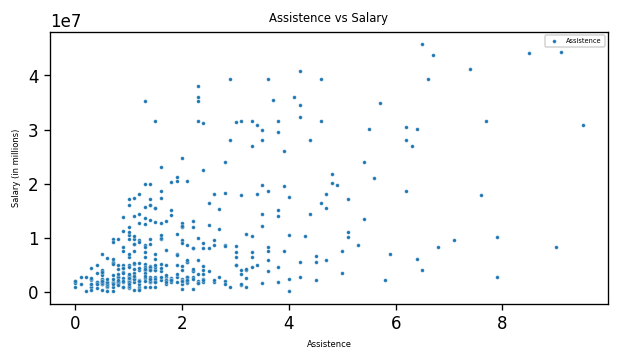

In [13]:
plt.figure(figsize=(6,3), dpi=120)

sns.scatterplot(data = data, x = "AST", y = "Salary", s=5)

plt.title('Assistence vs Salary', fontsize = 7)
plt.xlabel('Assistence', fontsize = 5)
plt.ylabel('Salary (in millions)', fontsize = 5)
plt.legend(["Assistence", "Salary"], fontsize = 4)

plt.show()

In [14]:
'''
With regards Salaries and Assistences in games, tendency is most definitely not certain.
Though it seems to be that players with lack of assistences are the ones with lowests
salaries, there is not a tendency that is replicated in all the other cases.
There are players whose salaries are within the highest range but their assistence 
si not. Though there are players who participate in all matches and they earned the highest
salaries, and also there are players with the same assistence profile whose salaries are
the lowests ones. Dispersion is extremelly high in this variables relationship.
'''

'\nWith regards Salaries and Assistences in games, tendency is most definitely not certain.\nThough it seems to be that players with lack of assistences are the ones with lowests\nsalaries, there is not a tendency that is replicated in all the other cases.\nThere are players whose salaries are within the highest range but their assistence \nsi not. Though there are players who participate in all matches and they earned the highest\nsalaries, and also there are players with the same assistence profile whose salaries are\nthe lowests ones. Dispersion is extremelly high in this variables relationship.\n'

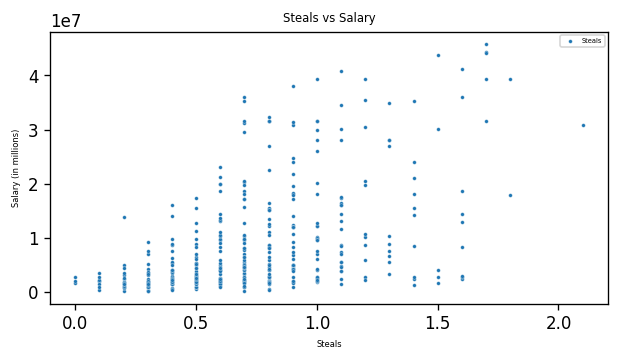

In [15]:
plt.figure(figsize=(6,3), dpi=120)

sns.scatterplot(data = data, x = "STL", y = "Salary", s=5)

plt.title('Steals vs Salary', fontsize = 7)
plt.xlabel('Steals', fontsize = 5)
plt.ylabel('Salary (in millions)', fontsize = 5)
plt.legend(["Steals", "Salary"], fontsize = 4)

plt.show()

In [16]:
'''
With regards Salaries and Steals made by each player in their games,
there is not a correlation between them.
As seen in this plot there are a huge variety of salaries in the same level
of steals.  
'''

'\nWith regards Salaries and Steals made by each player in their games,\nthere is not a correlation between them.\nAs seen in this plot there are a huge variety of salaries in the same level\nof steals.  \n'

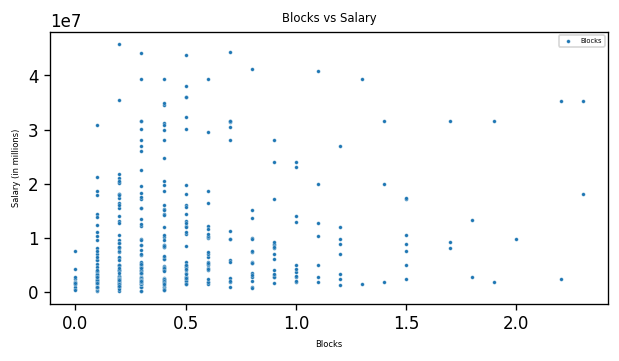

In [17]:
plt.figure(figsize=(6,3), dpi=120)

sns.scatterplot(data = data, x = "BLK", y = "Salary", s=5)

plt.title('Blocks vs Salary', fontsize = 7)
plt.xlabel('Blocks', fontsize = 5)
plt.ylabel('Salary (in millions)', fontsize = 5)
plt.legend(["Blocks", "Salary"], fontsize = 4)

plt.show()

In [18]:
'''
With regards Salaries and Blocks made by each player in their games,
there is not a correlation between them.
As seen in this plot there are a huge variety of salaries in the same level
of Blocks.  
'''

'\nWith regards Salaries and Blocks made by each player in their games,\nthere is not a correlation between them.\nAs seen in this plot there are a huge variety of salaries in the same level\nof Blocks.  \n'

1.2. What can we say about these distributions?

In [19]:
'''
As a brief overview of the analysis made above, it can be said that
Salaries have a tendency of positive and direct relation with points.
In addition, seems to have a tendency of direct and positive relation
with rebounds and assistances but in this particular case the dispersion
within the cases under analysis is huge.
Finally, there is no apreciable relation withing salaries and steals and
blocks, are variables which behave independently of salary changes.
''' 

'\nAs a brief overview of the analysis made above, it can be said that\nSalaries have a tendency of positive and direct relation with points.\nIn addition, seems to have a tendency of direct and positive relation\nwith rebounds and assistances but in this particular case the dispersion\nwithin the cases under analysis is huge.\nFinally, there is no apreciable relation withing salaries and steals and\nblocks, are variables which behave independently of salary changes.\n'

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

In [20]:
'''
Here, target and labels of my data set for splitting
In target: Salary column, In Labels: all the other columns of my dataset
'''

target = "Salary"
labels = data.columns.drop("Salary")

y = data[target]
X = data[labels]

In [21]:
'''
Split our dataset into testing and training set
In this case, our Y is only the Salary
Define the percentage of testing set according to the size of our data
And finally setting a random state in order to mantein the same testing selection
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=8)

### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [22]:
'''
Define the BaseLine model class
Fit model with the mean salary and tell it always to predict mean salary for every single item shown.
Within predict, the model will apply what it has learnt in fit
As a result, it will execute a vector with only mean salaries
'''

class BaselineModel():
    """A baseline model that always returns the same value, the mean of the players salary in the train data"""
    
    def fit(self, y_train):
        """
        Fit the training data. 
        
        Parameters
        ----------
        y_train: Union[pd.Series, np.ndarray]
            a pandas series or numpy array containing salary information
        """

        self.promedio = int(round(np.mean(y_train)))


    def predict(self, X):
        """
        Predict salaries 
        
        Parameters
        ----------
        X: Union[pd.DataFrame, pd.Series, np.ndarray]
            a pandas series, dataframe or numpy array with the 
            
        Returns
        -------
        np.ndarray
            a numpy array of the same length as X, with all elements equal to the mean salary calculated in fit()
        """

        vector_x = np.zeros(len(X))

        vector_x.fill(self.promedio)

        vector_x = vector_x.astype(int)

        return (vector_x)

In [23]:
'''
Once class is defined, with fit and predict functions, we save it into a variable called "modelo"
'''

modelo = BaselineModel()

In [24]:
'''
Execute the fit function to my y_train
'''

modelo.fit(y_train)

In [25]:
'''
Execute the predict function to my X_test and originate my "y" that will be compared to the y_test group of data
My y_predict returns a numpy array with the prediction of salaries (mean salaries) for each of the values it recived as imputs
'''

modelo.predict(X_test)
y_predict = modelo.predict(X_test)
y_predict

array([9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697, 9183697, 9183697, 9183697, 9183697, 9183697,
       9183697, 9183697])

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [26]:
'''
By analizing the model accuracy with the mean absolute error we are getting that
model prediction is far away from reality in more than 6millins USD
'''

error_baseline = mean_absolute_error(y_test, y_predict)

error_baseline = int(round(error_baseline))

error_baseline

6716417

### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

In [27]:
X_train 

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,AGE
251,1629642,Nassir Little,Trail Blazers,Forward,196,100,USA,2000-02-11,2,25,138.0,16.7,5.8,3.4,0.7,0.3,0.5,2022-03-07,"22 years, 1 months, 5 days"
169,203925,Joe Harris,Nets,Guard,198,100,USA,1991-09-06,7,33,414.0,25.6,11.1,3.2,1.6,0.5,0.2,2022-03-06,"30 years, 6 months, 10 days"
290,200794,Paul Millsap,76ers,Forward,201,117,USA,1985-02-10,15,47,1082.0,28.1,13.4,7.1,2.2,1.2,1.0,2022-03-07,"37 years, 1 months, 6 days"
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,15,2,1073.0,33.7,19.1,8.1,1.9,0.7,1.1,2022-03-06,"36 years, 7 months, 25 days"
445,1630172,Patrick Williams,Bulls,Forward,201,98,USA,2001-08-26,1,4,76.0,27.7,9.1,4.4,1.3,0.9,0.6,2022-03-07,"20 years, 6 months, 18 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,1629629,Cam Reddish,Knicks,Forward,203,98,USA,1999-09-01,2,10,131.0,25.0,10.5,3.2,1.3,1.1,0.4,2022-03-06,"22 years, 6 months, 15 days"
143,201959,Taj Gibson,Knicks,Forward,206,105,USA,1985-06-24,12,26,884.0,24.6,9.1,6.1,1.0,0.6,1.0,2022-03-06,"36 years, 8 months, 20 days"
140,1630568,Luka Garza,Pistons,Center,208,110,USA,1998-12-27,0,52,29.0,11.7,5.2,3.0,0.6,0.3,0.1,2022-03-07,"23 years, 2 months, 17 days"
380,1629013,Landry Shamet,Suns,Guard,193,86,USA,1997-03-13,3,26,243.0,23.2,8.8,1.8,1.6,0.5,0.1,2022-03-06,"25 years, 0 months, 3 days"


In [28]:
'''
Based on the splitted set I've already created, I defined new X test and train only considering players points
My y remains to be salaries
'''

xp_train = X_train["PTS"]
xp_test = X_test["PTS"]

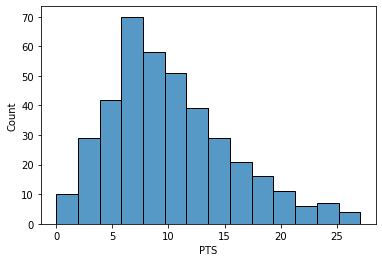

In [29]:
'''
Visualize my X train in order to understand data behaviour
'''

sns.histplot(data = xp_train)

In [30]:
'''
Define the scaler and call it into a new variable
'''

puntosMaxMin = MinMaxScaler()

In [31]:
'''
Train de model in X train and then, transform my X train and X test
'''

puntosMaxMin.fit(xp_train.values.reshape(-1,1))

MinMaxScaler()

In [32]:
xp_train = puntosMaxMin.transform(xp_train.values.reshape(-1,1))

In [33]:
xp_test = puntosMaxMin.transform(xp_test.values.reshape(-1,1))

In [34]:
'''
The train function is saved into a new df in order to visualize what the model has learn
As we can see, data has min values in 0 and max values 1, so scaler worked just fine
'''

xp_train = pd.DataFrame(xp_train)
xp_train.describe()

,0
count,393.000000
mean,0.376778
std,0.199143
min,0.000000
25%,0.228782
50%,0.339483
75%,0.490775
max,1.000000


1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [35]:
'''
Define my regressor model into a variable
'''

PointsModel = SGDRegressor()

In [36]:
PointsModel.fit(X = xp_train, y = y_train)

SGDRegressor()

In [37]:
PointsModel.predict (X = xp_test)

array([ 6999098.24023846,  6453795.84086528,  -226158.55145609,
       10407238.2363208 ,  5635842.24180552,  4272586.24337259,
       16814541.42895559, 12997424.63334337,  5363191.04211894,
         182818.24807379,  4136260.6435293 , 14360680.63177631,
       17768820.62785864,  8089703.03898481, -1453088.95004574,
        5635842.24180552,  2500353.44540977,  5908493.44149211,
       12588447.83381349, -1589414.54988903,  8089703.03898481,
        2909330.24493966,  9725610.23710433,  1955051.0460366 ,
       12997424.63334337,  1818725.44619331,   591795.04760367,
        7135423.84008175, -2543693.74879208,  4954214.24258906,
       19404727.82597816, 15587611.03036595, 30856078.21281482,
       -3361647.34785184,  2500353.44540977,  5635842.24180552,
        5363191.04211894,  8362354.23867139,  4136260.6435293 ,
        1818725.44619331,  3590958.24415612,  4272586.24337259,
       18450448.62707511, 20904309.4242544 ])

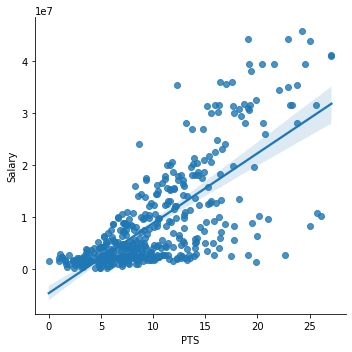

In [38]:
'''
As we can see in this plot, for players with points under aprox 4points
salaries predicted are negative because at that level regression line cuts to the zero-axis
'''

sns.lmplot(data = data, x = "PTS", y = "Salary")

In [39]:
'''
Save my y predicted by model into a varibable
'''

y_pointspredict = PointsModel.predict (X = xp_test)

In [40]:
'''
Evaluate model error with mean absolute error and saved into a variable
Baseline model, which predicts mean salaries brings a mean absolute error of 9m. USD
In this case, considering one varible, the error improves
'''

error_SGDRegressor = mean_absolute_error(y_test, y_pointspredict)

error_SGDRegressor = int(round(error_SGDRegressor))

error_SGDRegressor

4750528

1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [41]:
'''
Define my function within a dictionary and its parameters
Define 2 for loops so as to iterete for each value of the data with hyperparameters max_iter and eta0
Inside my function both hyperparameters have been named as maxit and eta
To fit and predict I maintein the variables defined previously in  SGDRegresor woithout hyperparameters
As to start my for loop, if mae es none as it is defined in the dictionary, print the difference between y test and y train
But in case the model have started, and mae is not none, print the smallest mae
There are going to be as much models as hyperparameters values I set: in this case 2+4= 8 models
Meaning each value of each hyperparameter is going to be executed with each of the values of the other hyperparameter defined
'''

def search_best_hyperparameters(max_iter, eta0):
    result = {
        "hyperparameters": {"max_iter": None, "eta0": None}, 
        "mae": None
    }
    
    # Complete your code here

    for maxit in max_iter:
      for eta in eta0:
        print(f"The maxit is {maxit} and eta is {eta}")
        HyperSGDR = SGDRegressor (max_iter = maxit, eta0 = eta, random_state = 8)
        HyperSGDR.fit (X = xp_train, y = y_train)
        y_hyperpredict = HyperSGDR.predict (X = xp_test)
        mae_hyper = (round(mean_absolute_error(y_hyperpredict,y_test)))
        print(mae_hyper)

        if result ["mae"] == None:
          result ["hyperparameters" ]["max_iter"] = maxit
          result ["hyperparameters" ]["eta0"] = eta
          result ["mae"] = mae_hyper

        else:
          if result ["mae"] > mae_hyper:
            result ["hyperparameters" ]["max_iter"] = maxit
            result ["hyperparameters" ]["eta0"] = eta
            result ["mae"] = mae_hyper

    return result

In [42]:
''' 
Define values for each hyperparameter
And print the min mae with its best combination of hyperparameters
'''

max_iter = [1000, 1000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

error_mae = search_best_hyperparameters(max_iter, eta0)
print(error_mae)

The maxit is 1000 and eta is 0.0001
5862874
The maxit is 1000 and eta is 0.001
4974314
The maxit is 1000 and eta is 0.01
4744814
The maxit is 1000 and eta is 0.1
4765031
The maxit is 1000000 and eta is 0.0001


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


4773067
The maxit is 1000000 and eta is 0.001
4772494
The maxit is 1000000 and eta is 0.01
4744814
The maxit is 1000000 and eta is 0.1
4765031
{'hyperparameters': {'max_iter': 1000, 'eta0': 0.01}, 'mae': 4744814}


In [43]:
'''
Print min mae obtained with the best combination of hyperparameters
'''

error_mae["mae"]

4744814

1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [44]:
'''
Compárison of the mean absolute error within baseline model, SDGR Regressor and SDGR Regressor with hyperparameters
'''

print("Mean Absolute Error for each model:")
print(f"Baseline: {error_baseline}")
print(f"Default SGDRegressor: {error_SGDRegressor}")
print(f"Best SGDRegressor: {error_mae['mae']}")

Mean Absolute Error for each model:
Baseline: 6716417
Default SGDRegressor: 4750528
Best SGDRegressor: 4744814


### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index):

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "TEAM_NAME", "SALARY"]

In [45]:
'''
Create a copy of my previous dataset only with the columns needed in this ex.
'''

data_mv = data[["PERSON_ID","PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "TEAM_NAME", "Salary"]].copy()
data_mv.set_index("PERSON_ID", inplace=True) 
data_mv.head()

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,TEAM_NAME,Salary
PERSON_ID,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,Forward,20,Raptors,2711280
203500,9.3,7.9,1.4,0.9,8,Center,12,Grizzlies,17073171
1628389,13.2,8.2,3.5,0.9,4,Center,14,Heat,28103550
1630583,3.3,2.4,0.5,0.3,0,Forward,30,Grizzlies,1994520
200746,19.1,8.1,1.9,1.1,15,Center,2,Nets,2641691


#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [46]:
'''
Info about the column required
'''

data_mv["DRAFT_NUMBER"].unique()

array(['20', '12', '14', '30', '2', '17', '21', '22', '15', '51', '3',
       '23', 'Undrafted', '43', '9', '1', '27', '6', '46', '7', '4', '40',
       '53', '48', '25', '19', '42', '18', '35', '31', '44', '39', '13',
       '11', '28', '10', '36', '45', '33', '8', '49', '32', '24', '41',
       '5', '34', '38', '29', '52', '26', nan, '37', '50', '16', '47',
       '55', '54', '58'], dtype=object)

In [47]:
'''
Data cleaning: replace NAN and Undrafted with zeros
As when print data, info is "str", transformation into int is needed
'''

data_mv['DRAFT_NUMBER'] = data_mv['DRAFT_NUMBER'].fillna(0)
data_mv['DRAFT_NUMBER'] = data_mv['DRAFT_NUMBER'].replace ("Undrafted",0)
data_mv['DRAFT_NUMBER'] = data_mv['DRAFT_NUMBER']. astype(int)
data_mv['DRAFT_NUMBER'].unique()

array([20, 12, 14, 30,  2, 17, 21, 22, 15, 51,  3, 23,  0, 43,  9,  1, 27,
        6, 46,  7,  4, 40, 53, 48, 25, 19, 42, 18, 35, 31, 44, 39, 13, 11,
       28, 10, 36, 45, 33,  8, 49, 32, 24, 41,  5, 34, 38, 29, 52, 26, 37,
       50, 16, 47, 55, 54, 58])

In [48]:
'''
Transform range of categories into named categories
Improtant to consider include lowest true so as not to lose border values
'''

draft_labels = ["undrafted", "firstround_lottery", "firstround_non_lottery", "second_round"]
data_mv["DRAFT"] = pd.cut(data_mv['DRAFT_NUMBER'], bins = [0,1,15,30,60], labels = draft_labels, include_lowest = True)
data_mv["DRAFT"].unique()

['firstround_non_lottery', 'firstround_lottery', 'second_round', 'undrafted']
Categories (4, object): ['undrafted' < 'firstround_lottery' < 'firstround_non_lottery' <
                         'second_round']

In [49]:
'''
Check data 
'''

data_mv["DRAFT"].value_counts()

firstround_lottery        147
firstround_non_lottery    105
second_round              102
undrafted                  83
Name: DRAFT, dtype: int64

In [50]:
'''
Check data 
'''

data_mv.head()

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,TEAM_NAME,Salary,DRAFT
PERSON_ID,,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,Forward,20,Raptors,2711280,firstround_non_lottery
203500,9.3,7.9,1.4,0.9,8,Center,12,Grizzlies,17073171,firstround_lottery
1628389,13.2,8.2,3.5,0.9,4,Center,14,Heat,28103550,firstround_lottery
1630583,3.3,2.4,0.5,0.3,0,Forward,30,Grizzlies,1994520,firstround_non_lottery
200746,19.1,8.1,1.9,1.1,15,Center,2,Nets,2641691,firstround_lottery


In [51]:
'''
Delete draft number column
Do not forget inplace true to maintein the change made
'''

data_mv.drop(columns = ["DRAFT_NUMBER"], inplace = True)
data_mv

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,TEAM_NAME,Salary,DRAFT
PERSON_ID,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,Forward,Raptors,2711280,firstround_non_lottery
203500,9.3,7.9,1.4,0.9,8,Center,Grizzlies,17073171,firstround_lottery
1628389,13.2,8.2,3.5,0.9,4,Center,Heat,28103550,firstround_lottery
1630583,3.3,2.4,0.5,0.3,0,Forward,Grizzlies,1994520,firstround_non_lottery
200746,19.1,8.1,1.9,1.1,15,Center,Nets,2641691,firstround_lottery
...,...,...,...,...,...,...,...,...,...
201152,12.9,5.9,1.8,0.4,14,Forward,Raptors,14190000,firstround_lottery
1629027,25.0,3.9,9.0,0.2,3,Guard,Hawks,8326471,firstround_lottery
1630209,6.0,5.7,1.0,0.4,0,Center,Heat,1489065,undrafted


1.12. Encode the categorical features: DRAFT, POSITION and TEAM_NAME

In [52]:
'''
Encode 3 features with Get Dummies method
'''

data_mv = pd.get_dummies(data_mv, columns = ["DRAFT", "POSITION","TEAM_NAME"])
data_mv

,PTS,REB,AST,BLK,SEASON_EXP,Salary,DRAFT_undrafted,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,2711280,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
203500,9.3,7.9,1.4,0.9,8,17073171,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1628389,13.2,8.2,3.5,0.9,4,28103550,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1630583,3.3,2.4,0.5,0.3,0,1994520,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
200746,19.1,8.1,1.9,1.1,15,2641691,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201152,12.9,5.9,1.8,0.4,14,14190000,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1629027,25.0,3.9,9.0,0.2,3,8326471,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1630209,6.0,5.7,1.0,0.4,0,1489065,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
'''
Check data
'''

data_mv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437 entries, 1630173 to 1627826
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PTS                           437 non-null    float64
 1   REB                           437 non-null    float64
 2   AST                           437 non-null    float64
 3   BLK                           437 non-null    float64
 4   SEASON_EXP                    437 non-null    int64  
 5   Salary                        437 non-null    int64  
 6   DRAFT_undrafted               437 non-null    uint8  
 7   DRAFT_firstround_lottery      437 non-null    uint8  
 8   DRAFT_firstround_non_lottery  437 non-null    uint8  
 9   DRAFT_second_round            437 non-null    uint8  
 10  POSITION_Center               437 non-null    uint8  
 11  POSITION_Forward              437 non-null    uint8  
 12  POSITION_Guard                437 non-null    uint8  


In [54]:
'''
Delete K-1
'''

data_mv.drop(columns = ["DRAFT_undrafted","POSITION_Center","TEAM_NAME_76ers"], inplace = True)
data_mv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437 entries, 1630173 to 1627826
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PTS                           437 non-null    float64
 1   REB                           437 non-null    float64
 2   AST                           437 non-null    float64
 3   BLK                           437 non-null    float64
 4   SEASON_EXP                    437 non-null    int64  
 5   Salary                        437 non-null    int64  
 6   DRAFT_firstround_lottery      437 non-null    uint8  
 7   DRAFT_firstround_non_lottery  437 non-null    uint8  
 8   DRAFT_second_round            437 non-null    uint8  
 9   POSITION_Forward              437 non-null    uint8  
 10  POSITION_Guard                437 non-null    uint8  
 11  TEAM_NAME_Bucks               437 non-null    uint8  
 12  TEAM_NAME_Bulls               437 non-null    uint8  


#### Modeling

1.13. Split the dataset into train and test

In [55]:
target= "Salary"
labels = data_mv.columns.drop("Salary")

y = data_mv[target]
X = data_mv[labels]

Xm_train, Xm_test, ym_train, ym_test = train_test_split(X, y, test_size=0.10, random_state=8)

1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number

In [56]:
'''
Define my scale model into a variable, in this case StandardScaler
Fit method into my x train with more than 1 feature
TAransform
'''

modeling_scaler = StandardScaler()

modeling_scaler.fit(Xm_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]])

Xm_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]] = modeling_scaler.transform (Xm_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]])

Xm_train

,PTS,REB,AST,BLK,SEASON_EXP,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,POSITION_Forward,POSITION_Guard,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
1629642,-0.818324,-0.331099,-0.857296,0.047326,-0.715073,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
203925,0.164996,-0.422285,-0.330039,-0.677309,0.475706,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
200794,0.591720,1.355835,0.021466,1.255051,2.380952,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
200746,1.649252,1.811763,-0.154286,1.496596,2.380952,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630172,-0.206068,0.124829,-0.505791,0.288871,-0.953229,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629629,0.053677,-0.422285,-0.505791,-0.194219,-0.715073,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
201959,-0.206068,0.899907,-0.681543,1.255051,1.666484,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1630568,-0.929643,-0.513470,-0.915880,-0.918854,-1.191385,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [57]:
'''
Transform method to x test
'''

Xm_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]] = modeling_scaler.transform (Xm_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]])

Xm_test

,PTS,REB,AST,BLK,SEASON_EXP,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,POSITION_Forward,POSITION_Guard,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
202362,-0.298834,-0.011949,0.431555,-0.918854,0.952017,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1627826,-0.373047,1.036686,-0.622959,0.771961,-0.000606,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1630215,-1.282154,-1.516512,-0.564375,-0.677309,-1.191385,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
202340,0.164996,-0.604656,-0.271455,-0.677309,1.428329,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1629726,-0.484366,-0.969398,-0.915880,-0.677309,-0.715073,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1628972,-0.669898,-0.103135,-0.330039,-0.918854,-0.476917,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2730,1.036996,3.498698,-0.447207,3.187410,2.857263,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1629018,0.517507,-0.923806,-0.447207,-0.677309,-0.476917,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
1628988,-0.521472,-1.106177,0.138634,-0.677309,-0.476917,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [58]:
def modeling_hyperparameters(max_iter, eta0):
    result = {
        "hyperparameters": {"max_iter": None, "eta0": None}, 
        "mae": None
    }


    for maxit in max_iter:
      for eta in eta0:
        print(f"The maxit is {maxit} and eta is {eta}")
        Modeling_HyperSGDR = SGDRegressor (max_iter = maxit, eta0 = eta, random_state = 8)
        Modeling_HyperSGDR.fit (X = Xm_train, y = ym_train)
        y_modelingpredict = Modeling_HyperSGDR.predict (X = Xm_test)
        mae_modeling = (round(mean_absolute_error(y_modelingpredict,ym_test)))
        print(mae_modeling)

        if result ["mae"] == None:
          result ["hyperparameters" ]["max_iter"] = maxit
          result ["hyperparameters" ]["eta0"] = eta
          result ["mae"] = mae_modeling

        else:
          if result ["mae"] > mae_modeling:
            result ["hyperparameters" ]["max_iter"] = maxit
            result ["hyperparameters" ]["eta0"] = eta
            result ["mae"] = mae_modeling

    return result

In [59]:
max_iter = [1000, 100000, 10000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

error_mae_modeling = modeling_hyperparameters(max_iter, eta0)
print(error_mae_modeling)

The maxit is 1000 and eta is 0.0001
4968161
The maxit is 1000 and eta is 0.001
4983442
The maxit is 1000 and eta is 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


5056739
The maxit is 1000 and eta is 0.1
5666009
The maxit is 100000 and eta is 0.0001


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


5176554
The maxit is 100000 and eta is 0.001
5214592
The maxit is 100000 and eta is 0.01
5056739
The maxit is 100000 and eta is 0.1
5666009
The maxit is 10000000 and eta is 0.0001
5274330
The maxit is 10000000 and eta is 0.001
5214592
The maxit is 10000000 and eta is 0.01
5056739
The maxit is 10000000 and eta is 0.1
5666009
{'hyperparameters': {'max_iter': 1000, 'eta0': 0.0001}, 'mae': 4968161}


In [60]:
error_mae_modeling["mae"]

4968161

1.16. How did the model performed compared to our univariate models? 

In [61]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {error_baseline}")
print(f"Default SGDRegressor: {error_SGDRegressor}")
print(f"Best SGDRegressor: {error_mae['mae']}")
print(f"Modeling SGDRegressor: {error_mae_modeling['mae']}")


Mean Absolute Error for each model:
Baseline: 6716417
Default SGDRegressor: 4750528
Best SGDRegressor: 4744814
Modeling SGDRegressor: 4968161


### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



In [62]:
'''
Useful to mention: as new variables are not required, previous variables can be used
'''

'\nUseful to mention: as new variables are not required, previous variables can be used\n'

1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [63]:
def tree_hyperparameters(max_depth, min_samples_leaf, max_features):
    result = {
        "hyperparameters": {"max_depth": None, "min_samples_leaf": None, "max_features": None}, 
        "mae": None
    }


    for maxde in max_depth:
      for minsamp in min_samples_leaf:
        for maxfeat in max_features:
          print(f"The maxde is {maxde}, minsamp is {minsamp} and maxfeat is {maxfeat}")
          TreeRegressor =  DecisionTreeRegressor (max_depth = maxde, min_samples_leaf = minsamp, max_features = maxfeat, random_state = 8)
          TreeRegressor.fit (X = Xm_train, y = ym_train)
          y_treepredict = TreeRegressor.predict (X = Xm_test)
          mae_tree = (round(mean_absolute_error(y_treepredict,ym_test)))
          print(mae_tree)

        if result ["mae"] == None:
          result ["hyperparameters" ]["max_depth"] = maxde
          result ["hyperparameters" ]["min_samples_leaf"] = minsamp
          result ["hyperparameters" ]["max_features"] = maxfeat
          result ["mae"] = mae_tree

        else:
          if result ["mae"] > mae_tree:
            result ["hyperparameters" ]["max_depth"] = maxde
            result ["hyperparameters" ]["min_samples_leaf"] = minsamp
            result ["hyperparameters" ]["max_features"] = maxfeat
            result ["mae"] = mae_tree

    return result

In [64]:
# List of hyperparameter example values
max_depth = [5, 10, 15, 20, 50] 
min_samples_leaf = [2, 10, 20, 50] # --> personas que cumplan las condiciones
max_features = [5, 10] #--> max de columnas que puede usar, por ende las nec agrupar, no puede ser mas de las columnas del dataset

In [65]:
error_mae_tree = tree_hyperparameters(max_depth, min_samples_leaf, max_features)
print(error_mae_tree)

The maxde is 5, minsamp is 2 and maxfeat is 5
5111352
The maxde is 5, minsamp is 2 and maxfeat is 10
3148545
The maxde is 5, minsamp is 10 and maxfeat is 5
4501730
The maxde is 5, minsamp is 10 and maxfeat is 10
3619471
The maxde is 5, minsamp is 20 and maxfeat is 5
4310054
The maxde is 5, minsamp is 20 and maxfeat is 10
3502207
The maxde is 5, minsamp is 50 and maxfeat is 5
4983890
The maxde is 5, minsamp is 50 and maxfeat is 10
3835041
The maxde is 10, minsamp is 2 and maxfeat is 5
2833108
The maxde is 10, minsamp is 2 and maxfeat is 10
2566679
The maxde is 10, minsamp is 10 and maxfeat is 5
4265594
The maxde is 10, minsamp is 10 and maxfeat is 10
2928526
The maxde is 10, minsamp is 20 and maxfeat is 5
4386553
The maxde is 10, minsamp is 20 and maxfeat is 10
3069641
The maxde is 10, minsamp is 50 and maxfeat is 5
4983890
The maxde is 10, minsamp is 50 and maxfeat is 10
3835041
The maxde is 15, minsamp is 2 and maxfeat is 5
2005864
The maxde is 15, minsamp is 2 and maxfeat is 10
32012

In [66]:
error_mae_tree["mae"]

2566679

In [67]:
'''
With my best parameters I save model prediction
'''

TreeRegressor = DecisionTreeRegressor (max_depth = 10, min_samples_leaf = 2, max_features = 10, random_state = 8)

In [68]:
TreeRegressor.fit(X = Xm_train, y=ym_train)

DecisionTreeRegressor(max_depth=10, max_features=10, min_samples_leaf=2,
                      random_state=8)

In [69]:
'''
Check ranking of importance of features considered by TreeRegressor
'''

cols = pd.DataFrame(Xm_train.columns, columns=["cols"])
imp = pd.DataFrame(TreeRegressor.feature_importances_, columns=["imp"])
col_imp = cols.join(imp)
col_imp.sort_values("imp", ascending=False)


,cols,imp
4,SEASON_EXP,0.340455
2,AST,0.315537
0,PTS,0.136978
1,REB,0.106586
3,BLK,0.034311
8,POSITION_Forward,0.015623
5,DRAFT_firstround_lottery,0.013771
36,TEAM_NAME_Trail Blazers,0.009379
17,TEAM_NAME_Heat,0.007051
22,TEAM_NAME_Lakers,0.005363


1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [70]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {error_baseline}")
print(f"Default SGDRegressor: {error_SGDRegressor}")
print(f"Best SGDRegressor: {error_mae['mae']}")
print(f"Modeling SGDRegressor: {error_mae_modeling['mae']}")
print(f"Decision Tree Regressor: {error_mae_tree['mae']}")

Mean Absolute Error for each model:
Baseline: 6716417
Default SGDRegressor: 4750528
Best SGDRegressor: 4744814
Modeling SGDRegressor: 4968161
Decision Tree Regressor: 2566679


### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

In [71]:
'''
In this case, the non linear model (Decision Tree Regressor) brings better results than the 3 linear model used
in terms of performance error.
To my mind, and regarding the theory in this course, linear models are so much more restricted regarding fitting curves of information
Whereas non linear models interpret better relation between features. As there are some of this features having no direct positive relation 
with our predictible variable (Salaries) or even no relation at all, for lineal models it gets hard to expose a realistic predition.
'''

'\nIn this case, the non linear model (Decision Tree Regressor) brings better results than the 3 linear model used\nin terms of performance error.\nTo my mind, and regarding the theory in this course, linear models are so much more restricted regarding fitting curves of information\nWhereas non linear models interpret better relation between features. As there are some of this features having no direct positive relation \nwith our predictible variable (Salaries) or even no relation at all, for lineal models it gets hard to expose a realistic predition.\n'

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

In [72]:
'''
As season exp is the feature most valuable in TreeRegressor, maybe we can train a model 
of rookies and experienced players, separately
'''

'\nAs season exp is the feature most valuable in TreeRegressor, maybe we can train a model \nof rookies and experienced players, separately\n'

## Star or no Star? Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1990_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [73]:
import pandas as pd
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)

In [74]:
type(all_nba_df)

pandas.core.frame.DataFrame

In [75]:
all_nba_df.head()

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
0,0,0,1,Alaa Abdelnaby,1990-91,1990,POR,43,0,6.7,...,0.474,0.568,2.1,0.3,0.1,0.3,0.5,0.9,3.1,0
1,1,0,2,Alaa Abdelnaby,1991-92,1991,POR,71,1,13.2,...,0.493,0.752,3.7,0.4,0.4,0.2,0.9,1.9,6.1,0
2,2,0,3,Alaa Abdelnaby,1992-93,1992,TOT,75,52,17.5,...,0.519,0.759,4.5,0.4,0.3,0.3,1.3,2.5,7.7,0
3,3,0,4,Alaa Abdelnaby,1993-94,1993,BOS,13,0,12.2,...,0.436,0.640,3.5,0.2,0.2,0.2,1.3,1.5,4.9,0
4,4,0,5,Alaa Abdelnaby,1994-95,1994,TOT,54,0,9.4,...,0.515,0.571,2.1,0.2,0.3,0.2,0.8,1.9,4.7,0


In [76]:
all_nba_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 0 to 15353
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season_id      14825 non-null  int64  
 1   player_id      14825 non-null  int64  
 2   player_season  14825 non-null  int64  
 3   player         14825 non-null  object 
 4   season         14825 non-null  object 
 5   season_start   14825 non-null  int64  
 6   team           14825 non-null  object 
 7   games          14825 non-null  int64  
 8   gamesstarted   14825 non-null  int64  
 9   mp             14825 non-null  float64
 10  fg_perc        14825 non-null  float64
 11  3p_perc        14825 non-null  float64
 12  2p_perc        14825 non-null  float64
 13  ft_perc        14825 non-null  float64
 14  trb            14825 non-null  float64
 15  ast            14825 non-null  float64
 16  stl            14825 non-null  float64
 17  blk            14825 non-null  float64
 18  tov   

In [77]:
len(all_nba_df)

14825

In [78]:
# number of rows

print(f"There are: {all_nba_df.shape[0]} rows")

There are: 14825 rows


In [79]:
# number of seasons

print(f"There are {len(all_nba_df['season'].unique())} different seasons")

There are 39 different seasons


In [80]:
# unique players

print(f"There are {len(all_nba_df['player'].unique())} number of players")

There are 2701 number of players


In [81]:
'''
As I was asked to find players selected and not selected, position
0 and 1 into values count solve it
'''

print(f" Players selected are: {all_nba_df['all_nba'].value_counts()[1]}")
print(f" Players non-selected are: {all_nba_df['all_nba'].value_counts()[0]}")

 Players selected are: 496
 Players non-selected are: 14329


### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'
       
    

In [82]:
'''
First step: define my new x and y: new y correspond to players selected and x some of the dataset columns
Previously, x was the complete set of columns
'''

target= "all_nba"
labels = ['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

y = all_nba_df[target]
X = all_nba_df[labels]

In [83]:
'''
Stratify tells model in its fit function that my y is not balanced
'''

Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, y, test_size=0.20, random_state=8, stratify=y)

In [84]:
Xs_test

,team,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
3324,GSW,23,7,20.2,0.409,0.000,0.415,0.660,3.7,1.7,1.1,0.2,1.7,2.3,6.2
1265,MIN,67,21,20.5,0.461,0.415,0.505,0.800,4.1,1.3,0.7,0.2,0.8,2.1,6.8
9008,HOU,37,1,6.4,0.403,0.280,0.468,0.800,1.1,0.3,0.2,0.2,0.5,0.8,2.4
2509,MEM,66,10,21.5,0.379,0.277,0.456,0.855,2.4,3.0,1.2,0.2,1.8,2.7,7.7
5178,SAC,78,75,30.7,0.507,0.235,0.513,0.732,7.0,1.6,0.5,1.3,2.4,3.4,14.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6741,UTA,82,0,17.9,0.398,0.284,0.438,0.763,2.1,4.6,0.6,0.0,1.9,1.1,4.7
3679,MIL,80,22,22.0,0.397,0.346,0.439,0.830,1.5,3.0,0.7,0.1,1.1,1.5,7.1
11764,MIL,80,79,38.9,0.465,0.350,0.482,0.791,6.3,3.1,1.3,0.9,3.4,2.8,21.1
10043,MIN,82,55,21.0,0.476,0.000,0.478,0.573,4.6,1.1,0.3,1.0,0.9,3.2,5.7


### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [85]:
total_no = all_nba_df['all_nba'].value_counts()[0]

total_set = len(all_nba_df)

accuracy = round((total_no/total_set)*100)

print(f"The model's accuracy is {accuracy}%")

The model's accuracy is 97%


2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

In [86]:
'''
The accuracy of this model is not a reliable result because as data in all_nba column has only 2 opcions,
and majority of players are not actually selected (not balanced y) chances of correctly predict are extremely high
'''

'\nThe accuracy of this model is not a reliable result because as data in all_nba column has only 2 opcions,\nand majority of players are not actually selected (not balanced y) chances of correctly predict are extremely high\n'

2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place)

In [87]:
'''
Check data: scalable data only the ones not in range 0-1
'''

all_nba_df.describe()

,season_id,player_id,player_season,season_start,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,7692.419292,1401.031838,5.218347,2001.034064,54.259966,26.067184,20.368209,0.439310,0.213769,0.459010,0.699923,3.572857,1.871433,0.674556,0.421167,1.255427,1.939204,8.257342,0.033457
std,4434.434514,812.455621,3.888109,10.179255,25.250798,29.621125,10.257796,0.094392,0.183338,0.099553,0.186416,2.563905,1.876222,0.481526,0.513631,0.816028,0.852881,6.010045,0.179833
min,0.000000,0.000000,1.000000,1979.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3854.000000,689.000000,2.000000,1993.000000,35.000000,0.000000,11.800000,0.403000,0.000000,0.427000,0.647000,1.700000,0.600000,0.300000,0.100000,0.600000,1.300000,3.600000,0.000000
50%,7694.000000,1408.000000,4.000000,2002.000000,62.000000,11.000000,19.700000,0.444000,0.257000,0.469000,0.742000,2.900000,1.300000,0.600000,0.300000,1.100000,1.900000,6.700000,0.000000
75%,11537.000000,2096.000000,8.000000,2010.000000,77.000000,52.000000,29.000000,0.486000,0.355000,0.505000,0.809000,4.800000,2.500000,0.900000,0.500000,1.700000,2.500000,11.700000,0.000000
max,15353.000000,2820.000000,21.000000,2017.000000,85.000000,83.000000,43.700000,1.000000,1.000000,1.000000,1.000000,18.700000,14.500000,3.700000,5.600000,5.800000,6.000000,37.100000,1.000000


In [88]:
'''
Scaler definition
'''

all_nba_Scaler = MinMaxScaler()

In [89]:
'''
Apply a mask to my x train so as to scale only the features needed
Transform x train y x test also with mask
'''

features_scaled = ["games", "gamesstarted", "mp", "trb", "ast", "stl", "blk", "tov", "pf", "pts"]

all_nba_Scaler.fit(Xs_train[features_scaled])

Xs_train[features_scaled] = all_nba_Scaler.transform(Xs_train[features_scaled])

Xs_test[features_scaled] = all_nba_Scaler.transform(Xs_test[features_scaled])

In [90]:
'''
Data check
'''

Xs_train.describe()

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
count,11860.000000,11860.000000,11860.000000,11860.000000,11860.000000,11860.000000,11860.000000,11860.000000,11860.000000,11860.000000,11860.000000,11860.000000,11860.000000,11860.000000
mean,0.633634,0.310929,0.463984,0.439289,0.214585,0.458830,0.699783,0.189610,0.132061,0.182013,0.074586,0.219622,0.321809,0.232156
std,0.300555,0.355939,0.234923,0.094959,0.183125,0.100011,0.187232,0.136467,0.133325,0.130655,0.091653,0.143506,0.142120,0.169316
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.404762,0.000000,0.270023,0.403000,0.000000,0.426000,0.647000,0.090909,0.042254,0.081081,0.017857,0.105263,0.216667,0.098870
50%,0.726190,0.120482,0.448513,0.445000,0.260000,0.469000,0.743000,0.155080,0.091549,0.162162,0.035714,0.192982,0.316667,0.186441
75%,0.904762,0.626506,0.659039,0.486000,0.355000,0.505000,0.810000,0.251337,0.176056,0.243243,0.089286,0.298246,0.416667,0.330508
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [91]:
'''
Define my regression model
'''

regression_model = LogisticRegression ()

In [92]:
'''
As team is string, it has letters but the model only accept numbers
Create a mask so as to get only numerical columns and fit/predict them
Describe brings only numerical columns, .columns brings a list of it
'''

numerical_columns = Xs_train.describe().columns

In [93]:
'''
Apply the mask created to x train and x test
Not apply it to y because is only one colum "all_nba
'''

regression_model.fit(X = Xs_train[numerical_columns], y = ys_train)

regression_model.predict (X = Xs_test[numerical_columns])

array([0, 0, 0, ..., 0, 0, 0])

In [94]:
'''
Save prediction into a new variable
'''

y_regression_predict = regression_model.predict (X = Xs_test[numerical_columns])

2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [95]:
accuracy_score(ys_test, y_regression_predict)

0.9831365935919055

In [96]:
precision_score(ys_test, y_regression_predict)

0.9298245614035088

In [97]:
recall_score(ys_test, y_regression_predict)

0.5353535353535354

In [98]:
f1_score(ys_test, y_regression_predict)

0.6794871794871795

From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [99]:
'''
Data check
'''

Xs_test["team"].unique()

array(['GSW', 'MIN', 'HOU', 'MEM', 'SAC', 'VAN', 'BOS', 'LAL', 'SEA',
       'NYK', 'MIA', 'NJN', 'ORL', 'DEN', 'IND', 'PHI', 'CLE', 'SAS',
       'LAC', 'CHI', 'TOT', 'CHH', 'MIL', 'POR', 'WSB', 'DAL', 'WAS',
       'DET', 'ATL', 'OKC', 'CHO', 'PHO', 'UTA', 'TOR', 'CHA', 'NOK',
       'NOP', 'NOH', 'BRK', 'KCK', 'SDC'], dtype=object)

In [100]:
'''
Define encode method into a variable
Sparse false is an attribute that allows bringing an np array and not a matrix
Create an other variable containing the column that is going to be encoded
Apply method fit and transform to this column
'''

onehot_encoder = OneHotEncoder(sparse = False, dtype = int)

variables_encoded = Xs_train["team"]

team_encoded = onehot_encoder.fit_transform((variables_encoded).values.reshape(-1, 1))

team_encoded

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [101]:
'''
As fit define the "parameters" of my encoding, 
Apply transform to x test so as they have the same size
'''

variables_encoded_test = Xs_test["team"]

team_encoded_test = onehot_encoder.transform((variables_encoded_test).values.reshape(-1, 1))

team_encoded_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [102]:
'''
Data check by calling the list of "categories" in the encoded column
Position zero for calling the first set of categories, if zero is not called a [] is printed
The result is a list of strings with the name of all teams
'''

onehot_encoder.categories_[0]

array(['ATL', 'BOS', 'BRK', 'CHA', 'CHH', 'CHI', 'CHO', 'CLE', 'DAL',
       'DEN', 'DET', 'GSW', 'HOU', 'IND', 'KCK', 'LAC', 'LAL', 'MEM',
       'MIA', 'MIL', 'MIN', 'NJN', 'NOH', 'NOK', 'NOP', 'NYK', 'OKC',
       'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'SDC', 'SEA', 'TOR',
       'TOT', 'UTA', 'VAN', 'WAS', 'WSB'], dtype=object)

In [103]:
'''
Create a column into my xs train with the list of categories about team name
Within this colum I add the arrays created for each team name with onehot encoder
Delete team column and K-1
Do not forget inplace true when dropping columns
'''

Xs_train[onehot_encoder.categories_[0]] = team_encoded
Xs_train.drop(columns="team", inplace = True)
Xs_train.drop(columns = "ATL", inplace = True)
Xs_train

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,SAC,SAS,SDC,SEA,TOR,TOT,UTA,VAN,WAS,WSB
14212,0.809524,0.072289,0.441648,0.412,0.327,0.429,0.750,0.192513,0.161972,0.162162,...,0,0,0,0,0,0,0,0,0,0
15260,0.845238,0.192771,0.560641,0.427,0.213,0.492,0.641,0.171123,0.211268,0.297297,...,0,0,0,0,0,0,0,0,0,0
243,0.690476,0.060241,0.334096,0.451,0.000,0.453,0.688,0.192513,0.063380,0.081081,...,0,0,0,0,0,0,0,0,0,0
5480,0.023810,0.000000,0.144165,0.222,0.000,0.222,0.625,0.144385,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
14192,0.809524,0.819277,0.688787,0.397,0.282,0.461,0.637,0.245989,0.183099,0.378378,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7263,0.785714,0.253012,0.411899,0.524,0.000,0.532,0.579,0.219251,0.042254,0.162162,...,0,0,0,0,0,0,0,0,0,1
14162,0.928571,0.951807,0.858124,0.469,0.360,0.504,0.734,0.438503,0.133803,0.351351,...,0,0,0,0,0,0,0,0,0,0
12322,0.714286,0.734940,0.594966,0.415,0.316,0.495,0.768,0.192513,0.105634,0.351351,...,0,0,0,0,0,0,0,0,0,0
12245,0.583333,0.469880,0.807780,0.472,0.395,0.486,0.823,0.395722,0.260563,0.216216,...,0,0,0,1,0,0,0,0,0,0


In [104]:
'''
Apply the same data cleaning to my x test set
So as it has the same size x train
'''

Xs_test[onehot_encoder.categories_[0]] = team_encoded_test
Xs_test.drop(columns="team", inplace = True)
Xs_test.drop(columns = "ATL", inplace = True)
Xs_test

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,SAC,SAS,SDC,SEA,TOR,TOT,UTA,VAN,WAS,WSB
3324,0.261905,0.084337,0.462243,0.409,0.000,0.415,0.660,0.197861,0.119718,0.297297,...,0,0,0,0,0,0,0,0,0,0
1265,0.785714,0.253012,0.469108,0.461,0.415,0.505,0.800,0.219251,0.091549,0.189189,...,0,0,0,0,0,0,0,0,0,0
9008,0.428571,0.012048,0.146453,0.403,0.280,0.468,0.800,0.058824,0.021127,0.054054,...,0,0,0,0,0,0,0,0,0,0
2509,0.773810,0.120482,0.491991,0.379,0.277,0.456,0.855,0.128342,0.211268,0.324324,...,0,0,0,0,0,0,0,0,0,0
5178,0.916667,0.903614,0.702517,0.507,0.235,0.513,0.732,0.374332,0.112676,0.135135,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6741,0.964286,0.000000,0.409611,0.398,0.284,0.438,0.763,0.112299,0.323944,0.162162,...,0,0,0,0,0,0,1,0,0,0
3679,0.940476,0.265060,0.503432,0.397,0.346,0.439,0.830,0.080214,0.211268,0.189189,...,0,0,0,0,0,0,0,0,0,0
11764,0.940476,0.951807,0.890160,0.465,0.350,0.482,0.791,0.336898,0.218310,0.351351,...,0,0,0,0,0,0,0,0,0,0
10043,0.964286,0.662651,0.480549,0.476,0.000,0.478,0.573,0.245989,0.077465,0.081081,...,0,0,0,0,0,0,0,0,0,0


#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [105]:
def lrf1_hyperparameters(tols, C, max_iter):
    result = {
        "hyperparameters": {"tol": None, "C": None, "max_iter": None}, 
        "f1": None
    }

    for p_tol in tols:
      for pc in C:
        for p_max_iter in max_iter:
          
          print(f"The parameters are: tol = {p_tol}, C = {pc}, and max_iter = {p_max_iter}")

          Model_f1_lr = LogisticRegression(tol = p_tol, C = pc, max_iter = p_max_iter, random_state = 8)
          Model_f1_lr.fit (X = Xs_train, y = ys_train)
          y_regression_predict = Model_f1_lr.predict (X = Xs_test)
          f1_error = f1_score(ys_test, y_regression_predict)
          precision_error = precision_score(ys_test, y_regression_predict)
          recall_error = recall_score(ys_test, y_regression_predict)

          if result ["f1"] == None or result["f1"]< f1_error:
            result ["hyperparameters" ]["tol"] = p_tol
            result ["hyperparameters" ]["C"] = pc
            result ["hyperparameters" ]["max_iter"] = p_max_iter
            result ["f1"] = f1_error

    return result

In [106]:
tols = [0.0001, 0.0003, 0.0007, 0.0011]
C = [5, 10, 15, 25]
max_iter = [500, 1000, 100000, 1000000]

error_lr = lrf1_hyperparameters(tols, C, max_iter)
print(error_lr)

The parameters are: tol = 0.0001, C = 5, and max_iter = 500
The parameters are: tol = 0.0001, C = 5, and max_iter = 1000
The parameters are: tol = 0.0001, C = 5, and max_iter = 100000
The parameters are: tol = 0.0001, C = 5, and max_iter = 1000000
The parameters are: tol = 0.0001, C = 10, and max_iter = 500
The parameters are: tol = 0.0001, C = 10, and max_iter = 1000
The parameters are: tol = 0.0001, C = 10, and max_iter = 100000
The parameters are: tol = 0.0001, C = 10, and max_iter = 1000000
The parameters are: tol = 0.0001, C = 15, and max_iter = 500
The parameters are: tol = 0.0001, C = 15, and max_iter = 1000
The parameters are: tol = 0.0001, C = 15, and max_iter = 100000
The parameters are: tol = 0.0001, C = 15, and max_iter = 1000000
The parameters are: tol = 0.0001, C = 25, and max_iter = 500
The parameters are: tol = 0.0001, C = 25, and max_iter = 1000
The parameters are: tol = 0.0001, C = 25, and max_iter = 100000
The parameters are: tol = 0.0001, C = 25, and max_iter = 1000

In [107]:
print(f"Best hyperparameters are: {error_lr['hyperparameters' ]['tol']}, {error_lr['hyperparameters' ]['C']}, {error_lr['hyperparameters' ]['max_iter']} and F1 Score: {error_lr['f1']}")

Best hyperparameters are: 0.0001, 25, 500 and F1 Score: 0.7262569832402236


#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [108]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [109]:
'''
Important:
x test --> all_nba_2018_df 
y test --> all_nba_2018_selections
'''

'\nImportant:\nx test --> all_nba_2018_df \ny test --> all_nba_2018_selections\n'

In [110]:
'''
Data check
'''

print(Xs_train.columns)
print(all_nba_2018_df.columns)
print(all_nba_2018_selections.columns)

Index(['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
       'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'BOS', 'BRK',
       'CHA', 'CHH', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU',
       'IND', 'KCK', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NJN', 'NOH',
       'NOK', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS',
       'SDC', 'SEA', 'TOR', 'TOT', 'UTA', 'VAN', 'WAS', 'WSB'],
      dtype='object')
Index(['season_id', 'player_id', 'player_season', 'player', 'season',
       'season_start', 'team', 'games', 'gamesstarted', 'mp', 'fg_perc',
       '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov',
       'pf', 'pts'],
      dtype='object')
Index(['player_id', 'player', 'all_nba'], dtype='object')


In [111]:
'''
Call the Scaler Model used to scaled my x train in 2.5 to scale my x test now
Then, only transform is needed
'''

all_nba_2018_df[features_scaled] = all_nba_Scaler.transform(all_nba_2018_df[features_scaled])

all_nba_2018_df

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
34,34,5,2,Alex Abrines,2018-19,2018,OKC,0.357143,0.024096,0.434783,...,0.323,0.500,0.923,0.080214,0.042254,0.135135,0.035714,0.087719,0.283333,0.149718
49,49,8,7,Quincy Acy,2018-19,2018,PHO,0.107143,0.000000,0.281465,...,0.133,0.667,0.700,0.133690,0.056338,0.027027,0.071429,0.070175,0.400000,0.048023
70,52,10,1,Jaylen Adams,2018-19,2018,ATL,0.392857,0.012048,0.288330,...,0.338,0.361,0.778,0.096257,0.133803,0.108108,0.017857,0.140351,0.216667,0.090395
71,71,13,6,Steven Adams,2018-19,2018,OKC,0.940476,0.963855,0.764302,...,0.000,0.596,0.500,0.508021,0.112676,0.405405,0.178571,0.298246,0.433333,0.392655
79,79,15,2,Bam Adebayo,2018-19,2018,MIA,0.964286,0.337349,0.533181,...,0.200,0.588,0.735,0.390374,0.154930,0.243243,0.142857,0.263158,0.416667,0.251412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,15319,2806,1,Trae Young,2018-19,2018,ATL,0.952381,0.975904,0.707094,...,0.324,0.477,0.829,0.197861,0.570423,0.243243,0.035714,0.666667,0.283333,0.539548
15333,15326,2808,6,Cody Zeller,2018-19,2018,CHO,0.571429,0.566265,0.581236,...,0.273,0.570,0.787,0.363636,0.147887,0.216216,0.142857,0.228070,0.550000,0.285311
15334,15334,2810,7,Tyler Zeller,2018-19,2018,TOT,0.059524,0.012048,0.354691,...,0.000,0.552,0.778,0.213904,0.049296,0.054054,0.089286,0.122807,0.550000,0.217514
15350,15350,2818,2,Ante Zizic,2018-19,2018,CLE,0.690476,0.301205,0.418764,...,0.000,0.553,0.705,0.288770,0.063380,0.054054,0.071429,0.175439,0.316667,0.220339


In [112]:
'''
Create a new variable with the column I need to encode
Onehot Encoder used in 2.8 is used here
Fit is already performed in 2.8, so only transform is needed
Then with a left join I only execute teams active in 2022
'''

variables_2018 = all_nba_2018_df["team"]

team_2018 = onehot_encoder.transform((variables_2018).values.reshape(-1, 1))

team_2018

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [113]:
'''
Print categories to see how is working
'''

onehot_encoder.categories_[0]

array(['ATL', 'BOS', 'BRK', 'CHA', 'CHH', 'CHI', 'CHO', 'CLE', 'DAL',
       'DEN', 'DET', 'GSW', 'HOU', 'IND', 'KCK', 'LAC', 'LAL', 'MEM',
       'MIA', 'MIL', 'MIN', 'NJN', 'NOH', 'NOK', 'NOP', 'NYK', 'OKC',
       'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'SDC', 'SEA', 'TOR',
       'TOT', 'UTA', 'VAN', 'WAS', 'WSB'], dtype=object)

In [114]:
'''
Create a new column that contains the encode
'''

all_nba_2018_df[onehot_encoder.categories_[0]] = team_2018


In [115]:
'''
Data check
'''

all_nba_2018_df

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,SAC,SAS,SDC,SEA,TOR,TOT,UTA,VAN,WAS,WSB
34,34,5,2,Alex Abrines,2018-19,2018,OKC,0.357143,0.024096,0.434783,...,0,0,0,0,0,0,0,0,0,0
49,49,8,7,Quincy Acy,2018-19,2018,PHO,0.107143,0.000000,0.281465,...,0,0,0,0,0,0,0,0,0,0
70,52,10,1,Jaylen Adams,2018-19,2018,ATL,0.392857,0.012048,0.288330,...,0,0,0,0,0,0,0,0,0,0
71,71,13,6,Steven Adams,2018-19,2018,OKC,0.940476,0.963855,0.764302,...,0,0,0,0,0,0,0,0,0,0
79,79,15,2,Bam Adebayo,2018-19,2018,MIA,0.964286,0.337349,0.533181,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,15319,2806,1,Trae Young,2018-19,2018,ATL,0.952381,0.975904,0.707094,...,0,0,0,0,0,0,0,0,0,0
15333,15326,2808,6,Cody Zeller,2018-19,2018,CHO,0.571429,0.566265,0.581236,...,0,0,0,0,0,0,0,0,0,0
15334,15334,2810,7,Tyler Zeller,2018-19,2018,TOT,0.059524,0.012048,0.354691,...,0,0,0,0,0,1,0,0,0,0
15350,15350,2818,2,Ante Zizic,2018-19,2018,CLE,0.690476,0.301205,0.418764,...,0,0,0,0,0,0,0,0,0,0


In [116]:
'''
Delete team column and K-1 after encoding
Also deleting columns not needed
'''

all_nba_2018_df.drop(columns = "team", inplace = True)
all_nba_2018_df.drop(columns = "ATL", inplace = True)
all_nba_2018_df.drop(columns = ["season_id", "player_id", "player_season", "player", "season", "season_start"], inplace = True)
all_nba_2018_df

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,SAC,SAS,SDC,SEA,TOR,TOT,UTA,VAN,WAS,WSB
34,0.357143,0.024096,0.434783,0.357,0.323,0.500,0.923,0.080214,0.042254,0.135135,...,0,0,0,0,0,0,0,0,0,0
49,0.107143,0.000000,0.281465,0.222,0.133,0.667,0.700,0.133690,0.056338,0.027027,...,0,0,0,0,0,0,0,0,0,0
70,0.392857,0.012048,0.288330,0.345,0.338,0.361,0.778,0.096257,0.133803,0.108108,...,0,0,0,0,0,0,0,0,0,0
71,0.940476,0.963855,0.764302,0.595,0.000,0.596,0.500,0.508021,0.112676,0.405405,...,0,0,0,0,0,0,0,0,0,0
79,0.964286,0.337349,0.533181,0.576,0.200,0.588,0.735,0.390374,0.154930,0.243243,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,0.952381,0.975904,0.707094,0.418,0.324,0.477,0.829,0.197861,0.570423,0.243243,...,0,0,0,0,0,0,0,0,0,0
15333,0.571429,0.566265,0.581236,0.551,0.273,0.570,0.787,0.363636,0.147887,0.216216,...,0,0,0,0,0,0,0,0,0,0
15334,0.059524,0.012048,0.354691,0.533,0.000,0.552,0.778,0.213904,0.049296,0.054054,...,0,0,0,0,0,1,0,0,0,0
15350,0.690476,0.301205,0.418764,0.553,0.000,0.553,0.705,0.288770,0.063380,0.054054,...,0,0,0,0,0,0,0,0,0,0


In [117]:
'''
Make a copy of the data frame to use it in 2.16
'''

new_all_nba_2018_df = all_nba_2018_df.copy()

2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [118]:
'''
Model defined in 2.9 with the best hyperparameters is saved into a new variable here
Then, trainned with fit function
'''

model_bestparameters = LogisticRegression(tol = error_lr["hyperparameters" ]["tol"], C = error_lr["hyperparameters" ]["C"], max_iter = error_lr["hyperparameters" ]["max_iter"])

model_bestparameters.fit(Xs_train, ys_train)


LogisticRegression(C=25, max_iter=500)

In [119]:
'''
Perform predict
With len consult I check that the number of rows are ok
'''

y_bestparameters = model_bestparameters.predict(X = all_nba_2018_df)

print(len(y_bestparameters))

530


In [120]:
'''
Compare y train with y test regarding 3 different formulas
'''

f1_evaluate = f1_score(all_nba_2018_selections["all_nba"], y_bestparameters)
precision_evaluate = precision_score(all_nba_2018_selections["all_nba"], y_bestparameters)
recall_evaluate = recall_score(all_nba_2018_selections["all_nba"], y_bestparameters)

print(f"f1 score: {f1_evaluate:.2%}")
print(f"precision_evaluate: {precision_evaluate:.2%}")
print(f"recall_evaluate: {recall_evaluate:.2%}")


f1 score: 71.79%
precision_evaluate: 58.33%
recall_evaluate: 93.33%


2.12. Analyze the results, what do you think it is happening?

In [121]:
'''
Analyzing the results: CONFUSION MATRIX
Rows --> what is REAL
Columns --> what the model predicted
505 asserts of players not selected, 14 asserts of players selected in all_nba,
10 errors in all_nba model prediction, this players are not selected and the model consider them as positive
1 error in exclude this player of all_nba but actually this player was one of the selected ones

Conclusion:
Model is selecting a lot of players because there are a lot of them with probability equal 1 value 
Because is setting 1 probability to all players with +50% which is no a reliable condition
Besides, havingo more than expected list of players selected, is hard to go wrong.
As is "easy" to accert, recall value is extremelly high
But this, is not because the model prediction is perfect but because is selecting too much players
'''

confusion_matrix(all_nba_2018_selections["all_nba"], y_bestparameters)

array([[505,  10],
       [  1,  14]])

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [122]:
# ver: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba
# a mi modelo le aplique una funcion fit, una predict y ahora un funcion proba
# traigo de ese array solo la columna de probaqbilidad positiva de quedar en allnba (posicion 1)

'''
To my best parameters model I apply a predict proba to obtain an array
with all the probabilitis of my x test
This array has 2 probabilities: prob of being 0 and prob of being 1
I call only position 1 because it matters to me only prob of 1: being selected
'''

a = model_bestparameters.predict_proba(all_nba_2018_df)
a[:,1]


array([2.93923127e-07, 1.20876534e-07, 2.45781413e-08, 9.87005219e-02,
       2.66868326e-04, 1.19039366e-08, 1.29102306e-08, 9.12108903e-01,
       2.13876376e-07, 1.57581961e-07, 3.25959835e-03, 5.10165159e-06,
       9.38110897e-04, 8.02651765e-08, 7.09970131e-05, 3.81665719e-08,
       9.16006505e-10, 9.99501344e-01, 5.18831743e-10, 1.60245532e-05,
       2.50296353e-07, 5.34528015e-06, 1.77719721e-03, 4.31620654e-03,
       1.49491261e-01, 7.32941409e-08, 3.58856593e-04, 6.84686353e-09,
       1.14749081e-08, 1.08849630e-03, 2.17014454e-06, 2.54333815e-05,
       2.17184924e-03, 3.07580761e-05, 3.42372199e-07, 4.67289549e-05,
       2.07514145e-07, 1.57770197e-06, 1.41474368e-05, 6.66773248e-01,
       2.13163050e-06, 4.69308505e-06, 4.08941855e-06, 1.50137020e-07,
       1.11219713e-06, 1.36966378e-05, 1.05054745e-10, 9.49685183e-06,
       2.09647424e-05, 1.87327885e-06, 3.40416019e-07, 1.52707132e-03,
       4.91020840e-07, 2.55500690e-01, 4.80810147e-07, 1.02960405e-04,
      

In [123]:
'''
Create a column in my x test that contains this probabilities
'''

all_nba_2018_df["all_nba_probability"] = a[:,1]
all_nba_2018_df["all_nba_probability"] = round(all_nba_2018_df["all_nba_probability"],3)
all_nba_2018_df["all_nba_probability"]

34       0.000
49       0.000
70       0.000
71       0.099
79       0.000
         ...  
15319    0.095
15333    0.000
15334    0.000
15350    0.000
15354    0.000
Name: all_nba_probability, Length: 530, dtype: float64

In [124]:
'''
Data check
'''

all_nba_2018_df

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,SAS,SDC,SEA,TOR,TOT,UTA,VAN,WAS,WSB,all_nba_probability
34,0.357143,0.024096,0.434783,0.357,0.323,0.500,0.923,0.080214,0.042254,0.135135,...,0,0,0,0,0,0,0,0,0,0.000
49,0.107143,0.000000,0.281465,0.222,0.133,0.667,0.700,0.133690,0.056338,0.027027,...,0,0,0,0,0,0,0,0,0,0.000
70,0.392857,0.012048,0.288330,0.345,0.338,0.361,0.778,0.096257,0.133803,0.108108,...,0,0,0,0,0,0,0,0,0,0.000
71,0.940476,0.963855,0.764302,0.595,0.000,0.596,0.500,0.508021,0.112676,0.405405,...,0,0,0,0,0,0,0,0,0,0.099
79,0.964286,0.337349,0.533181,0.576,0.200,0.588,0.735,0.390374,0.154930,0.243243,...,0,0,0,0,0,0,0,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,0.952381,0.975904,0.707094,0.418,0.324,0.477,0.829,0.197861,0.570423,0.243243,...,0,0,0,0,0,0,0,0,0,0.095
15333,0.571429,0.566265,0.581236,0.551,0.273,0.570,0.787,0.363636,0.147887,0.216216,...,0,0,0,0,0,0,0,0,0,0.000
15334,0.059524,0.012048,0.354691,0.533,0.000,0.552,0.778,0.213904,0.049296,0.054054,...,0,0,0,0,1,0,0,0,0,0.000
15350,0.690476,0.301205,0.418764,0.553,0.000,0.553,0.705,0.288770,0.063380,0.054054,...,0,0,0,0,0,0,0,0,0,0.000


2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [125]:
'''
Read again CSV so as to merge the column dropped previously
'''

player_all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)

all_nba_2018_df = all_nba_2018_df.merge(player_all_nba_2018_df["player"], right_index = True, left_index = True)

all_nba_2018_df

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,SDC,SEA,TOR,TOT,UTA,VAN,WAS,WSB,all_nba_probability,player
34,0.357143,0.024096,0.434783,0.357,0.323,0.500,0.923,0.080214,0.042254,0.135135,...,0,0,0,0,0,0,0,0,0.000,Alex Abrines
49,0.107143,0.000000,0.281465,0.222,0.133,0.667,0.700,0.133690,0.056338,0.027027,...,0,0,0,0,0,0,0,0,0.000,Quincy Acy
70,0.392857,0.012048,0.288330,0.345,0.338,0.361,0.778,0.096257,0.133803,0.108108,...,0,0,0,0,0,0,0,0,0.000,Jaylen Adams
71,0.940476,0.963855,0.764302,0.595,0.000,0.596,0.500,0.508021,0.112676,0.405405,...,0,0,0,0,0,0,0,0,0.099,Steven Adams
79,0.964286,0.337349,0.533181,0.576,0.200,0.588,0.735,0.390374,0.154930,0.243243,...,0,0,0,0,0,0,0,0,0.000,Bam Adebayo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15319,0.952381,0.975904,0.707094,0.418,0.324,0.477,0.829,0.197861,0.570423,0.243243,...,0,0,0,0,0,0,0,0,0.095,Trae Young
15333,0.571429,0.566265,0.581236,0.551,0.273,0.570,0.787,0.363636,0.147887,0.216216,...,0,0,0,0,0,0,0,0,0.000,Cody Zeller
15334,0.059524,0.012048,0.354691,0.533,0.000,0.552,0.778,0.213904,0.049296,0.054054,...,0,0,0,1,0,0,0,0,0.000,Tyler Zeller
15350,0.690476,0.301205,0.418764,0.553,0.000,0.553,0.705,0.288770,0.063380,0.054054,...,0,0,0,0,0,0,0,0,0.000,Ante Zizic


In [126]:
# sort values: https://stackoverflow.com/questions/37787698/how-to-sort-pandas-dataframe-from-one-column
# head las primeras 15
# estos son los que apostamos nosotros que salian en nba
# los guardo en una variable nueva porque los necesito mas abajo

'''
Sort values to order them by probability and bring the first 15 players
Save them into a variable
'''

all_nba_2018_df = all_nba_2018_df.sort_values(by = ["all_nba_probability"], ascending = False)
all_nba_2018_df.head(15)
best_15 = all_nba_2018_df.head(15)
best_15

,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,SDC,SEA,TOR,TOT,UTA,VAN,WAS,WSB,all_nba_probability,player
453,0.845238,0.867470,0.750572,0.578,0.256,0.641,0.729,0.668449,0.415493,0.351351,...,0,0,0,0,0,0,0,0,1.000,Giannis Antetokounmpo
5604,0.916667,0.939759,0.842105,0.442,0.368,0.528,0.879,0.352941,0.528169,0.540541,...,0,0,0,0,0,0,0,0,0.999,James Harden
6857,0.642857,0.662651,0.805492,0.510,0.339,0.582,0.665,0.454545,0.584507,0.351351,...,0,0,0,0,0,0,0,0,0.998,LeBron James
14479,0.857143,0.879518,0.823799,0.428,0.290,0.481,0.656,0.593583,0.753521,0.513514,...,0,0,0,0,0,0,0,0,0.987,Russell Westbrook
4145,0.750000,0.771084,0.771167,0.484,0.300,0.535,0.804,0.727273,0.260563,0.189189,...,0,0,0,0,0,0,0,0,0.984,Joel Embiid
4895,0.904762,0.927711,0.844394,0.438,0.386,0.484,0.839,0.438503,0.288732,0.594595,...,0,0,0,0,0,0,0,0,0.964,Paul George
3908,0.916667,0.939759,0.791762,0.521,0.353,0.587,0.885,0.342246,0.415493,0.189189,...,0,0,0,0,0,0,0,0,0.962,Kevin Durant
14027,0.940476,0.963855,0.718535,0.518,0.364,0.549,0.789,0.641711,0.267606,0.270270,...,0,0,0,0,0,0,0,0,0.943,Nikola Vucevic
168,0.952381,0.975904,0.759725,0.519,0.238,0.528,0.847,0.491979,0.169014,0.135135,...,0,0,0,0,0,0,0,0,0.912,LaMarcus Aldridge
3794,0.928571,0.951807,0.766590,0.533,0.132,0.548,0.590,0.834225,0.098592,0.459459,...,0,0,0,0,0,0,0,0,0.875,Andre Drummond


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [128]:
#  Players actually selected from the all_nba_2018_selections dataset

mask = all_nba_2018_selections['all_nba'] == 1
actually_selected = all_nba_2018_selections[mask]['player']

print(f"The players actually in NBA are: {list(actually_selected)}")
print(f"Total of: {len(actually_selected)} players")

The players actually in NBA are: ['Giannis Antetokounmpo', 'Stephen Curry', 'Kevin Durant', 'Joel Embiid', 'Paul George', 'Rudy Gobert', 'Blake Griffin', 'James Harden', 'Kyrie Irving', 'LeBron James', 'Nikola Jokic', 'Kawhi Leonard', 'Damian Lillard', 'Kemba Walker', 'Russell Westbrook']
Total of: 15 players


In [129]:
#  Players actually selected missing from OUR predictions

Difference = (set(list(actually_selected))).difference(set(list(best_15["player"])))

print(f"Players actually selected missing from OUR predictions are: {Difference}")
print(f"Total of: {len(Difference)} players")

Players actually selected missing from OUR predictions are: {'Damian Lillard', 'Kemba Walker', 'Stephen Curry', 'Nikola Jokic', 'Kyrie Irving'}
Total of: 5 players


In [130]:
#  Players in our predictions not selected 

Difference2 = (set(list(best_15["player"]))).difference(set(list(actually_selected)))

print(f"Players in our predictions not selected are: {Difference2}")
print(f"Total of: {len(Difference2)} players")

Players in our predictions not selected are: {'Karl-Anthony Towns', 'Nikola Vucevic', 'Andre Drummond', 'Anthony Davis', 'LaMarcus Aldridge'}
Total of: 5 players


2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [131]:
class AllNbaSingleSeasonClassifier():
    
    def __init__(self, model):
        """
        Class constructor
        
        Parameters
        ----------
        model: BaseEstimator
            a Scikit learn estimator
        """
        self._model = model
        
        # guarde el modelo en la clase para poder usaerlo (self._model)


    def predict(self, X):
        """
        Predicts all nba selections. This classifier will limit the number
        of positive instances to 15
        
        Parameters
        ----------
        X: pd.DataFrame
            a dataframe with the players data
            
        Returns
        -------
        np.ndarray
            An array of the same length as y, with 15 true results based on the players with most probabilities of
            beign selected
        """

        '''
        make a copy of the DF given and create a variable with the predict proba
        '''
        model_predict = X.copy()
        y_prob = self._model.predict_proba(model_predict)

        '''
        call the 1 positions (probability of YES) and create a DF with that info
        '''
        probability = y_prob[:,1]
        probabilities = pd.DataFrame(probability,columns = ["probability_nba"])
        
        '''
        get the best 15 in a new df
        '''
        prob_15 = probabilities.nlargest(15,"probability_nba")

        '''
        new column with all zeros
        '''
        probabilities["selected"] = 0

        '''
        replacing with loc 0 with 1 en cases the players are in best 15, I got ONLY 1df with all the information 
        '''
        probabilities.loc[prob_15.index, ["selected"]] = 1

        '''
        my df has only 2 columns (probabilities and 0/1) --> transform my df into a numpy array but only getting my 0/1 column
        '''
        return (probabilities["selected"].values)   


'''
call the trained model from 2.13 and predict over my copy of df made in 2.10
'''
classifier_ss = AllNbaSingleSeasonClassifier(model_bestparameters)

y_pred_classifier = classifier_ss.predict(new_all_nba_2018_df) 

2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [132]:
f1_evaluate = f1_score(all_nba_2018_selections["all_nba"], y_pred_classifier)
precision_evaluate = precision_score(all_nba_2018_selections["all_nba"], y_pred_classifier)
recall_evaluate = recall_score(all_nba_2018_selections["all_nba"], y_pred_classifier)

print(f"f1_score: {f1_evaluate:.2%}")
print(f"precision_evaluate: {precision_evaluate:.2%}")
print(f"recall_evaluate: {recall_evaluate:.2%}")

f1_score: 66.67%
precision_evaluate: 66.67%
recall_evaluate: 66.67%


#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

In [133]:
'''
Model has predict correctly that 510 players are not selected and 10 are selected
But it fail in choosing 5 players that are not in all_nba and other 5 players that are
actually selected and this model did not consider

As false positive and false negative are the same number of players,
precision and recall percentages are equal, so that, F1 that combine both
is also 66.67%

The main problem of this model is that our dataset is so much unbalanced and we are
not choosing players correctly considering their position.
'''

confusion_matrix(all_nba_2018_selections["all_nba"], y_pred_classifier)

array([[510,   5],
       [  5,  10]])

2.19. What do you think we could do to improve our model?

In [134]:
'''
To improve this model we can choose players taking into account their position
Meaning,choosing only 3 center players, 6 forward players and 6 backward players
'''

'\nTo improve this model we can choose players taking into account their position\nMeaning,choosing only 3 center players, 6 forward players and 6 backward players\n'

### Optional: Oversampling

2.19. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

## Optional: Developing a Linear Regressor class from scratch

Our last task will be to code a Linear Regression algorithm using Gradient Descent as its optimization algorithm in Python. The structure of the class is presented below, you should use numpy for numerical computation.

3.1. Write a LinearRegression class that implements fit and predict methods, and uses gradient descent as optimization algorithm

In [135]:
    
class LinearRegressor:
    """Linear regression algorithm class. Implements gradient descent as optimization algorithm"""
    
    def __init__(self, epochs: int, learning_rate: float):
        """
        Class constructor
        
        Parameters
        ----------
        epochs: int
            number of epochs to run gradient descent
        learning_rate: float
            rate of update of the gradients
        """


    def _gradient_descent():
        """
        Gradient descent algorithm
        """


    def fit(self, X, y):
        """
        Fit the model according to the given training data.
        
        Parameters
        ----------
        X: np.ndarray
        y: np.ndarray
        """
             
    def predict(self, X):
        """
        Predict
        
        Parameters
        ----------
        X: np.ndarray
        
        Returns
        -------
        np.ndarray
            array with predictions
        """


IndentationError: ignored

3.2. Train a regression model with the data from the first section to calculate players salaries using points per game. Try with a few different values (3 or 4 for each should suffice) for epochs and learning rate parameters, calculate MAE for all results and save the best result along with the parameters values used.

3.3. Evaluate the model performance on the test set, and compare with the result you obtained using SGDRegressor from scikit-learn.